## Robson de Oliveira Caldas - 1831134018

## 1 - Banco de dados

### Conjunto de LOGs de um servidor Web Apache2.

O objetivo é classificar os acessos como reais (feitos por humanos) e fake (feitos por bots), a fim de bloquear os fakes e reduzir o tráfego desnecessário no servidor.

Bots, spiders e outros rastreadores que acessam as páginas dinâmicas podem causar uso extensivo de recursos (memória e CPU). Isso pode levar a uma alta carga no servidor e atrasar o site legítimo. Existem ainda os bots maliciosos, que vasculham o servidor em busca de vulnerabilidades constantemente.


#### Multiplos arquivos de log

Os logs são armazenados no servidor em arquivos separados, aqui vamos juntar todos em um só arquivo para o processamento:

In [1]:
# import lib.merge_logs as merge
# merge.merge('log/access.log')

## 2 - Pré-processamento

### Logs no arquivo 'access.log.all', criar um DataFrame Pandas:

In [2]:
"""
RCaldas Log Parser.
"""
import sys,os
import time
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter

try:
    log = open('log/access.log.all')
except IOError:
    print(__doc__,"\nErro ao ler o arquivo de log.")
    sys.exit(1)
    
df = []
tags_total = []
count = 0

### Regex para pegar os campos corretos de cada linha
regc = re.compile('^(?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) .+'
                  ' \[(?P<time>[0-9]+/\S+:\d{2}:\d{2}:\d{2} .+)\] '
                  '\"(?P<met>\S+) (?P<urn>\S+) \S+\" (?P<code>\d+) '
                  '(?P<size>\d+) \"(?P<identd>[^\"]+)\" \"(?P<agent>[^\"]*)\"')

### Loop em cada linha do arquivo:
for line in log:
    try:
        ### Armazenar os dados capturados com o regex (IP, URN, Código HTTP, Tamanho):
        m = regc.match(line)
        ip, urn, code, size = m.group('ip', 'urn', 'code', 'size')
        
        ### Converter data e hora para formato datetime
        time = datetime.datetime.strptime(m.group('time'), '%d/%b/%Y:%H:%M:%S %z')
        
        ### Método já categorizado = GET: 0, POST: 1, OUTRO: 2
        if m.group('met') == 'GET': metodo = 0
        elif m.group('met') == 'POST': metodo = 1
        else: metodo = 2
        
        ### Tem algo no identd?
        if m.group('identd') == '-': identd = 0
        else: identd = 1
        
        ### Informaçoes do agente acumulando em 'tags_total'
        agent = m.group('agent')
        tags = []
        for i in agent.split():
            i = i.strip(';/)().,')
            i = i.split('/')[0]
            tags.append(i)
            tags_total.append(i)

    except:
        ### print('Linha fora do padrão:\n', line)
        continue
        
    ### Alimentar o dataframe com os dados:
    df.append({'IP': ip, 'Data': time, 'Metodo': metodo, 'Request': urn, 
               'Code': code, 'Bytes': size, 'Identd': identd, 'Agent': agent})
    count += 1

log.close()
df = pd.DataFrame(df)

### Converter as colunas numéricas em inteiro:
df['Bytes'] = pd.to_numeric(df['Bytes'])
df['Code'] = pd.to_numeric(df['Code'])

print('Total de registros: ', count,'\n')
df.info()

Total de registros:  16869 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16869 entries, 0 to 16868
Data columns (total 8 columns):
Agent      16869 non-null object
Bytes      16869 non-null int64
Code       16869 non-null int64
Data       16869 non-null datetime64[ns, UTC-03:00]
IP         16869 non-null object
Identd     16869 non-null int64
Metodo     16869 non-null int64
Request    16869 non-null object
dtypes: datetime64[ns, UTC-03:00](1), int64(4), object(3)
memory usage: 1.0+ MB


**Descrição das variáveis:**

- Agent   : informações do agente (browser) como versão, compatibilidades, sistema operacional...
- Bytes   : Tamanho em bytes da requisição
- Code    : Código HTTP recebido (200: OK, 404: Not Found, 301: Redirect ...)
- Data    : Data e hora do acesso
- IP      : IP do cliente
- Identd  : Campo de identificação, presente geralmente em acessos já iniciados, não no primeiro GET.
- Metodo  : Metodo da requisição (GET: 0, POST:1, OUTROS:2)
- Request : URN solicitado para o servidor (Ex: /wp-admin.php)

In [3]:
df.head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request
0,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-27 00:08:19-03:00,209.239.118.173,0,0,/wp-login.php
1,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-27 00:08:20-03:00,209.239.118.173,0,1,/wp-login.php
2,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3566,200,2019-03-27 00:08:20-03:00,209.239.118.173,0,1,/xmlrpc.php
3,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,558,301,2019-03-27 00:12:11-03:00,27.133.137.100,0,0,/wp.rar
4,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3587,404,2019-03-27 00:12:12-03:00,27.133.137.100,1,0,/wp.rar


## 3 - Análise da Distribuição

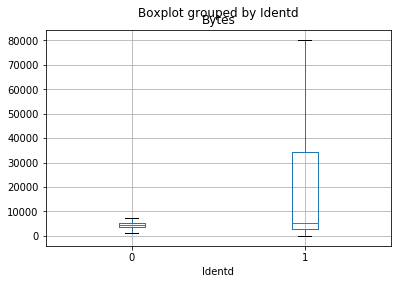

In [4]:
## Tamanho da requisição por Identd, excluindo os outliers
%matplotlib inline
df.boxplot(column='Bytes', by = 'Identd', showfliers=False)

### Aqui podemos perceber que os Bytes são maiores quando o campo Identd existe

### Podemos registrar os logs com bytes altos para o algoritimo de classificação funcionar melhor

In [5]:
## Ver os Códigos HTTP registrados
##  **Muitos GETs retornando 404 significa algum bot fazendo varredura por bruteforce**
df['Code'].value_counts()

200    14200
301     1870
404      577
400      131
421       74
302        5
500        4
206        2
503        2
405        2
304        2
Name: Code, dtype: int64

In [6]:
## Ver a média do tamanho dos requests **requests grandes sem identd tem mais chances de ser bot**
df['Request'].apply(len).describe()

count    16869.000000
mean        42.023949
std         36.539471
min          1.000000
25%         13.000000
50%         35.000000
75%         63.000000
max        534.000000
Name: Request, dtype: float64

In [7]:
## Analisar os registros com Request maiores que 63 (75%) que não tenham Identd
df[(df['Request'].apply(len)>=63) & (df['Identd']==0)]

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request
2003,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:26-03:00,115.68.182.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...
2005,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:28-03:00,115.68.182.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...
2007,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:31-03:00,115.68.182.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...
2009,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:34-03:00,115.68.182.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...
2011,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,714,301,2019-03-26 18:19:37-03:00,115.68.182.152,0,1,/wp-admin/admin-post.php?swp_debug=load_option...
2013,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,714,301,2019-03-26 18:19:39-03:00,115.68.182.152,0,1,/wp-admin/admin-ajax.php?swp_debug=load_option...
2194,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3456,200,2019-03-26 21:06:12-03:00,107.191.108.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...
2195,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3294,400,2019-03-26 21:06:13-03:00,107.191.108.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...
2196,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3456,200,2019-03-26 21:06:13-03:00,107.191.108.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...
2197,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3294,400,2019-03-26 21:06:14-03:00,107.191.108.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...


### Foi possivel perceber que com esse filtro quase todos os registros parecem ser falsos, menos os de Agent iPhone, talvez o iPhone não utilize o campo Identd

### Foi notável, também a presença de Agents estranhos como o seguinte:


In [8]:
df['Agent'].iloc[16070]

'}__test|O:21:\\'

### Vamos analisar os Agents mais comuns e procurar por registros que não possuam nenhuma das palavras comuns:

In [9]:
### Gerar a lista dos nomes mais usadas no campo 'Agent':
tagsorted = sorted([(value, key) for (key,value) in Counter(tags_total).items()], reverse=True)
tagsorted[:20]

[(16226, 'Mozilla'),
 (12280, 'Gecko'),
 (8708, 'Windows'),
 (8605, 'NT'),
 (8182, 'like'),
 (6994, 'KHTML'),
 (6994, 'AppleWebKit'),
 (6549, 'Safari'),
 (5276, 'Firefox'),
 (5115, 'Linux'),
 (4876, 'Chrome'),
 (4232, 'Trident'),
 (4154, 'compatible'),
 (4014, '6.1'),
 (3896, 'X11'),
 (3891, 'x86_64'),
 (3464, 'Ubuntu'),
 (3458, 'rv:62.0'),
 (3190, 'MSIE'),
 (2895, 'OS')]

In [10]:
## Pegar apenas os nomes para usar na busca
topagents = [x[1] for x in tagsorted[:10]]
for top in topagents: print(top)

Mozilla
Gecko
Windows
NT
like
KHTML
AppleWebKit
Safari
Firefox
Linux


In [11]:
## Analisar os logs que não possuem nenhum dos 'topagents' no campo 'Agent'
# df[~df['Agent'].isin(topagents)] ???

In [12]:
## Descobrir os IPs que mais aparecem 
df['IP'].value_counts().head()

23.100.232.233     1098
118.24.58.56        441
45.56.114.108       339
189.61.19.38        314
185.211.245.199     275
Name: IP, dtype: int64

In [13]:
## Ver os registros do IP que mais aparece
df[df['IP']==df['IP'].value_counts().head().keys()[0]].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request
9911,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,30621,200,2019-03-22 11:53:50-03:00,23.100.232.233,0,0,/
9912,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,2719,200,2019-03-22 11:53:51-03:00,23.100.232.233,1,0,/wp-content/themes/jupiter/js/ie/placeholder.js
9913,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,7551,200,2019-03-22 11:53:52-03:00,23.100.232.233,1,0,/wp-content/plugins/revslider/public/assets/cs...
9914,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,3808,200,2019-03-22 11:53:52-03:00,23.100.232.233,1,0,/wp-content/uploads/smile_fonts/Defaults/Defau...
9915,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,20313,200,2019-03-22 11:53:52-03:00,23.100.232.233,1,0,/wp-content/themes/jupiter/stylesheet/css/them...


## 4 - Extração de características

Algumas características já foram extraidas no pré-processamento como o método (GET=0, POST=1, Outros=2) e a existencia do campo 'identd' marcado como 0 ou 1.

Falta extrair as caracteristicas do campo 'Request' e 'Agent' buscando a existencia de palavras chave e marcando isso no dataframe.


## 5 - Classificação

Testar com MLP, SVM e CNN

## 9 - Futuras Implementações

- Verificar se o request solicitado existe no servidor, se não tiver atribuir grande peso para classificar como bot.
- Identificar e registrar o intervalo em segundos entre um acesos e outro do mesmo IP para melhor identificar bots.
- Pegar GeoIP Country name de cada IP
- Incluir na leitura dos logs, talvez com javascript, informaçoes de movimento do mouse na página para melhor identificar bots.


In [14]:

# sorted(Counter(tags).items(), key=lambda x: x[1])
#     print(re.match(regex, line))
#     if re.search('^189.', line):
#         print(line+'\n')

#     ip = re.findall('^([0-9]+.[0-9]+.[0-9]+.[0-9]+) ', line)
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) - "(.*?)" "(.*?)"'
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+)'

## Começa e termina com caractere comum, continua com nao espaços:
# [a-zA-Z0-9]\S*@\S*[a-zA-Z] 

# map(''.join, re.findall(r'\"(.*?)\"|\[(.*?)\]|(\S+)', row))

## Projeto Final

- Escolher um banco de dados de qualquer natureza (imagem, série temporal, dados de comércio, dados bancários, etc); https://toolbox.google.com/datasetsearch
- Fazer pré-processamento (se necessário);
- Extração de características (PCA, filtros digitais, etc);
- Classificação com um dos algoritmos estudado: PCA, K_means, MLP, SVM, BOOSTING, REGRESSÃO LOGÍSTICA, CNN, RNN e GAN.
- Usar validação cruzada para separar dados de treino e validação e matriz de confusão para cálculo das métricas.

### IMPORTANTÍSSIMO:

- Contextualizar sua classificação, qual o problema a ser solucionado com os seus resultados?
- Levantar as dificuldades, limitações, inconsistências e imprecisões nas soluções propostas.
- Sugerir futuras implementações.
- Para o seu banco de dados existem outros trabalhos de classificação na literatura? (site para pesquisa: https://sci-hub.tw/)
